In [95]:
''' 
#Lo dejo comentado para que tu lo comentes y descomentes a necesidad
!pip install matplotlib
!pip install seaborn 
'''

' \n#Lo dejo comentado para que tu lo comentes y descomentes a necesidad\n!pip install matplotlib\n!pip install seaborn \n'

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [97]:
df_raw = pd.read_excel("../data/TABLA_ACCIDENTES_22.xlsx", sheet_name=0) #el excel tiene dos hojas pero solo queremos la primera

df_raw.head()

,ID_ACCIDENTE,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,ZONA,ZONA_AGRUPADA,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,1,2022,1,6,3,1,0,NaN,1,1,...,999,1,1,6,1,NaN,NaN,1,998,3
1,2,2022,1,5,16,1,1059,NaN,1,1,...,999,1,3,1,3,NaN,NaN,1,998,2
2,3,2022,1,6,21,1,0,NaN,1,1,...,0,1,1,6,2,NaN,NaN,1,998,2
3,4,2022,1,7,12,1,0,NaN,1,1,...,999,1,3,1,3,NaN,NaN,1,998,1
4,5,2022,1,7,12,1,0,NaN,1,1,...,999,1,1,1,1,NaN,NaN,1,998,3


In [98]:
#Esto es solo para no tener que cargar el dataframe cada vez que nos equivoquemos en algo, con ejecutar esta línea vale
df = df_raw.copy()

In [99]:
df.shape

(97916, 73)

El Dataframe del que se parte contiene 97916 filas (registros) y 17 columnas (datos distintos)

In [100]:
df.duplicated().sum()

0

No hay filas duplicadas en el Dataset

In [101]:
df.columns

Index(['ID_ACCIDENTE', 'ANYO', 'MES', 'DIA_SEMANA', 'HORA', 'COD_PROVINCIA',
       'COD_MUNICIPIO', 'ISLA', 'ZONA', 'ZONA_AGRUPADA', 'CARRETERA', 'KM',
       'SENTIDO_1F', 'TITULARIDAD_VIA', 'TIPO_VIA', 'TIPO_ACCIDENTE',
       'TOTAL_MU24H', 'TOTAL_HG24H', 'TOTAL_HL24H', 'TOTAL_VICTIMAS_24H',
       'TOTAL_MU30DF', 'TOTAL_HG30DF', 'TOTAL_HL30DF', 'TOTAL_VICTIMAS_30DF',
       'TOTAL_VEHICULOS', 'TOT_PEAT_MU24H', 'TOT_BICI_MU24H',
       'TOT_CICLO_MU24H', 'TOT_MOTO_MU24H', 'TOT_TUR_MU24H', 'TOT_FURG_MU24H',
       'TOT_CAM_MENOS3500_MU24H', 'TOT_CAM_MAS3500_MU24H', 'TOT_BUS_MU24H',
       'TOT_OTRO_MU24H', 'TOT_SINESPECIF_MU24H', 'TOT_PEAT_MU30DF',
       'TOT_BICI_MU30DF', 'TOT_CICLO_MU30DF', 'TOT_MOTO_MU30DF',
       'TOT_TUR_MU30DF', 'TOT_FURG_MU30DF', 'TOT_CAM_MENOS3500_MU30DF',
       'TOT_CAM_MAS3500_MU30DF', 'TOT_BUS_MU30DF', 'TOT_VMP_MU30DF',
       'TOT_OTRO_MU30DF', 'TOT_SINESPECIF_MU30DF', 'NUDO', 'NUDO_INFO',
       'CARRETERA_CRUCE', 'PRIORI_NORMA', 'PRIORI_AGENTE', 'PR

Hay hasta 31 columnas indicando la gravedad del accidente, por lo que lo primero que haremos será agruparlas todas en una donde tan solo se indique la gravedad como leve, grave o mortal.

Lo primero para ello es entender nuestros datos, por ejemplo: 
    
    ¿La columna que indica el número de fallecidos computados a 30 días integra los fallecidos computados a 24 horas o son independientes?
    ¿La columna que indica el número de fallecidos computados a 30 días integra las victimas computadas a 24 horas o son independientes?

In [102]:
print(f"Total de fallecidos registrados en el accidente computados a 24 horas mas que computados a 30 días {df.loc[df['TOTAL_MU24H'] > df['TOTAL_MU30DF']].shape[0]} \n")

print(f"Total de víctimas registrados en el accidente computados a 24 horas mas que computados a 30 días {df.loc[df['TOTAL_VICTIMAS_24H'] > df['TOTAL_VICTIMAS_30DF']].shape[0]})")

Total de fallecidos registrados en el accidente computados a 24 horas mas que computados a 30 días 0 

Total de víctimas registrados en el accidente computados a 24 horas mas que computados a 30 días 0)


No existe ningun accidente con más fallecidos ni victimas computadas a 24 horas que a 30 días, se asume por tanto, que el registro computado a 30 días ya incluye el de 24 horas.. 


No vamos a eliminar el resto de columnas sobre fallecidos ya que aunque no se vayan a incluir en nuestro modelo pueden ser interesantes para analizar estadísticas.

Otra cuestión parecida a la anterior es si el número de heridos hospitalizados incluye también a los que acabaron muriendo. Este problema es más complicado, ya que si una víctima es hospitalizada y acaba muriendo en los 30 días posteriores es posible que cuente dentro de los dos grupos, no obstante dado que el total de victimas se calcula con la suma de fallecidos, hospitalizados y no hospitalizados, en teoría si alguien acaba falleciendo en el hospital no debería contar como victima hospitalizada ya que sino al hacer la suma estarían contando doble las victimas en estos casos, pero vamos a comprobarlo.

In [103]:
df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H','TOTAL_HG30DF']].loc[df['TOTAL_MU30DF'] > df['TOTAL_HG30DF']]

,TOTAL_MU24H,TOTAL_MU30DF,TOTAL_HG24H,TOTAL_HG30DF
16,1,1,0,0
133,1,1,0,0
196,1,1,0,0
324,0,1,1,0
446,2,2,0,0
...,...,...,...,...
97610,1,1,0,0
97619,1,1,0,0
97622,1,1,0,0
97646,0,1,1,0


Como se puede comprobar hay columnas en las que el número de fallecidos en 30 días supera al de ingresados en el mismo periodo, aunque pudiera ser que fallecieron fuera sin ser ingresados. 

Pero filas como la 16 donde hay dos víctimas, y una falleció en 24 horas y la otra en los 30 días indican que en efecto la columna de fallecidos es independiente de la de hospitalizados en el mismo periodo.

In [104]:
#más hospitalizados en 24 horas que en 30 días
df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H', 'TOTAL_HG30DF','TOTAL_HL24H','TOTAL_HL30DF','TOTAL_VICTIMAS_24H','TOTAL_VICTIMAS_30DF']].loc[df['TOTAL_HG24H'] > df['TOTAL_HG30DF']]

,TOTAL_MU24H,TOTAL_MU30DF,TOTAL_HG24H,TOTAL_HG30DF,TOTAL_HL24H,TOTAL_HL30DF,TOTAL_VICTIMAS_24H,TOTAL_VICTIMAS_30DF
324,0,1,1,0,0,0,1,1
605,0,1,1,0,0,0,1,1
620,0,1,4,3,0,0,4,4
1568,0,1,1,0,2,2,3,3
1763,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...
97226,0,1,1,0,0,0,1,1
97229,0,1,1,0,0,0,1,1
97506,0,1,1,0,0,0,1,1
97646,0,1,1,0,0,0,1,1


Es curioso que si que haya algunos casos donde hay más hospitalizados en 24 horas que en 30 días, por lo que a priori parece que en este caso estár hospitalizado en las primeras 24 horas no implica contar como que estuviste hospitalizado en los 30 días posteriores, no obstante hay algunas incoherencias:
- En todos los casos hubo un fallecido en 30 días y ninguno en 24 horas (Cuando solo era una victima)
- Si estuvo hospitalizado menos de 24 horas y no falleció en esas horas cabría pensar que se trata de un accidente leve, pero solo hay 232 casos cuando los accidentes leves deberían ser mayoritarios, además falleció en los siguientes 30 días lo que indica que fue un accidente mortal.

Teoría: Como hemos mencionado anteriormente alguien fallecido en 30 días no será incluido en la columna de hospitalizados en ese periodo ya que generaría un conteo doble en el total de víctimas, no obstante, si será incluido en los hospitalizados en 24 horas ya que eso no genera ningúna incoherencia. Por tanto, los casos que observamos en la tabla anterior son casos donde la victima del accidente fue llevada al hospital de inmediato (Hospitalizado 24 horas), no falleció en las primeras 24 horas pero sí falleció en los siguientes días y lo sacaron de la lista de hospitalizados en 30 días. En estos casos la víctima nunca fallece en las primeras 24 horas porque de hacerlo se le sacaría del número de hospitalizados en ese periodo (y en el siguiente también ya que contaría como fallecido).

Vamos a confirmar esta teoría, para ello se tienen que dar varias condiciones, que son:
- 1º Si el número de fallecidos en 24 horas es 0 y el número de fallecidos en 30 días es igual al de ingresados en 24 horas y mayor a 0, el número de ingresados en 30 días nunca podrá ser ni igual ni mayor al de fallecidos en 30 días.
- 2º En los casos donde el número de fallecidos computados a 24 horas y 30 días sea el mismo, y el número de ingresados computados a 24 horas y 30 días también lo sea, serán siempre casos en donde hubo más de una víctima (al menos una que falleció y una que sobrevivió) <font color="red">Revisar segunda condición, porque ya, la primera fila no cumple eso de al menos una que falleció y otra que sobrevivio </font>
- 3º El total de víctimas en computados a 24 horas y computados a 30 días siempre será el mismo.

In [105]:
# 1º Condición
condicion_1 = df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H', 'TOTAL_HG30DF','TOTAL_VICTIMAS_24H',
       'TOTAL_VICTIMAS_30DF','TOTAL_HL24H','TOTAL_HL30DF']].loc[(df['TOTAL_MU24H'] == 0) & (df['TOTAL_MU30DF']==df['TOTAL_HG24H']) & (df['TOTAL_MU30DF']>0) & (df['TOTAL_HG30DF']>=df['TOTAL_MU30DF'])]

#2º Condición
condicion_2 = df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H', 'TOTAL_HG30DF','TOTAL_VICTIMAS_24H',
       'TOTAL_VICTIMAS_30DF']].loc[(df['TOTAL_MU24H'] == df['TOTAL_MU30DF']) & (df['TOTAL_HG24H']==df['TOTAL_MU30DF']) & (df['TOTAL_HG24H']==1)]

#3º Condición
condicion_3 = df.loc[df['TOTAL_VICTIMAS_24H'] != df['TOTAL_VICTIMAS_30DF']]



Todas las condiciones se han cumplido, por lo que parece que la teoría planteada era correcta. Además se termina de concluir que los registros computados a 30 días incluyen los computados a 24 horas.

In [106]:
# ALEX: Este creo que no aporta nada pero lo he dejado por si opinas lo contrario, si estás de acuerdo bórralo
df[['TOTAL_MU30DF','TOTAL_HG30DF','TOTAL_HL30DF','TOTAL_VICTIMAS_30DF']].loc[(df['TOTAL_MU30DF'] == df['TOTAL_HG30DF']) & (df['TOTAL_MU30DF'] > 1)]

,TOTAL_MU30DF,TOTAL_HG30DF,TOTAL_HL30DF,TOTAL_VICTIMAS_30DF
12034,2,2,2,6
12851,2,2,0,4
29576,2,2,6,10
30031,2,2,2,6
31432,3,3,0,6
83079,2,2,0,4
88434,2,2,6,10
91138,2,2,0,4


In [107]:
#Aquí habría que ver si borramos la de no hospitalizados en 24 horas, nos sirve de algo?
df = df.drop(['TOTAL_MU24H','TOTAL_VICTIMAS_24H'], axis=1)

Diferenciaremos entre tres tipos de accidentes: Mortal, leve y sin lesiones. Ya que en el dataset no se indica el tipo de lesión vamos a establecer el siguiente criterio:

- Mortal = La víctima fallece (en cualquier periodo).
- Leve = Fue al hospital
- Sin lesiones = No fue al hospital

Se establece la columna tipo de accidente en función de la prioridad:

- Si hay una victima mortal, el accidente se clasifica como  'Mortal'
- Si no hay ningun accidente mortal pero al menos una víctima ha sido ingresada en el hospital, el accidente se clasifica como 'Leve'
- Si no hay ningun accidente mortal ni nadie ha sido ingresado en el hospital el accidente se clasifica como 'Sin_lesiones'

In [108]:

def clasificar_accidentes(column):
    if column['TOTAL_MU30DF'] > 0:
        return 'Mortal'
    elif column['TOTAL_HG30DF'] > 0 & column['TOTAL_MU30DF'] == 0: 
        return 'Leve'
    else: 
        return 'Sin_lesiones'

df['TYP_ACC'] = df.apply(clasificar_accidentes, axis=1) # Crear la columna TYP_ACC basada en las condicione



Se contabiliza el número de accidentes mortales, leves y sin lesiones que hay en el dataset

In [109]:
cont_mortales = 0
cont_leves = 0
cont_sin_lesiones = 0

for i in df['TYP_ACC']:
    if i == "Mortal":
        cont_mortales += 1
    elif i == "Leve":
        cont_leves += 1
    else:
        cont_sin_lesiones +=1

total_accidentes = cont_mortales + cont_leves + cont_sin_lesiones #len(df)
porc_mortales = (cont_mortales/total_accidentes)*100
porc_leves = (cont_leves/total_accidentes)*100
porc_sin_lesiones = (cont_sin_lesiones/total_accidentes)*100

print(f"El numero de accidentes mortales es {cont_mortales} un {porc_mortales:.2f}% del total de accidentes\n")
print(f"El número de accidentes leves es {cont_leves} un {porc_leves:.2f}% del total de accidentes \n")
print(f"El número de accidentes sin lesiones es {cont_sin_lesiones} un {porc_sin_lesiones:.2f}% del total de accidentes")


El numero de accidentes mortales es 1620 un 1.65% del total de accidentes

El número de accidentes leves es 7410 un 7.57% del total de accidentes 

El número de accidentes sin lesiones es 88886 un 90.78% del total de accidentes


Se extrae que la gran mayoría de accidentes han sido sin lesiones, una minoria leves y una gran minoria mortales.

# Limpieza y simplificación del Dataset

In [110]:
# Eliminar irrelevantes
df = df.drop(['ID_ACCIDENTE','ZONA_AGRUPADA','ANYO','TITULARIDAD_VIA','TOT_PEAT_MU24H','TOT_BICI_MU24H','TOT_CICLO_MU24H', 
        'TOT_MOTO_MU24H', 'TOT_TUR_MU24H','TOT_FURG_MU24H','TOT_CAM_MENOS3500_MU24H','TOT_CAM_MAS3500_MU24H', 'TOT_BUS_MU24H',
       'TOT_OTRO_MU24H','TOT_SINESPECIF_MU24H','TOT_BUS_MU30DF','TOT_SINESPECIF_MU30DF','NUDO_INFO','CARRETERA_CRUCE','CONDICION_NIEBLA',
       'CONDICION_VIENTO','TOT_CAM_MENOS3500_MU30DF','SENTIDO_1F','PRIORI_NORMA', 'PRIORI_AGENTE', 'PRIORI_SEMAFORO', 'PRIORI_VERT_STOP',
       'PRIORI_VERT_CEDA', 'PRIORI_HORIZ_STOP', 'PRIORI_HORIZ_CEDA','PRIORI_MARCAS', 'PRIORI_PEA_NO_ELEV', 'PRIORI_PEA_ELEV',
       'PRIORI_MARCA_CICLOS', 'ACERA','TIPO_VIA','VISIB_RESTRINGIDA_POR','CONDICION_NIVEL_CIRCULA','PRIORI_CIRCUNSTANCIAL',
       'PRIORI_OTRA','TRAZADO_PLANTA','COD_MUNICIPIO', 'ISLA',], axis=1)


<font color="red">La de no hospitalizados 24 horas quieres que las eliminemos? no se me ocurre que valgan para nada no? </font>


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MES                     97916 non-null  int64  
 1   DIA_SEMANA              97916 non-null  int64  
 2   HORA                    97916 non-null  int64  
 3   COD_PROVINCIA           97916 non-null  int64  
 4   ZONA                    97916 non-null  int64  
 5   CARRETERA               97916 non-null  object 
 6   KM                      50944 non-null  float64
 7   TIPO_ACCIDENTE          97916 non-null  int64  
 8   TOTAL_HG24H             97916 non-null  int64  
 9   TOTAL_HL24H             97916 non-null  int64  
 10  TOTAL_MU30DF            97916 non-null  int64  
 11  TOTAL_HG30DF            97916 non-null  int64  
 12  TOTAL_HL30DF            97916 non-null  int64  
 13  TOTAL_VICTIMAS_30DF     97916 non-null  int64  
 14  TOTAL_VEHICULOS         97916 non-null

Parece que el dataset no tiene valores nulos excepto por la columna 'ISLA' que es normal porque la mayoría de accidentes ocurrieron en el territorio peninsular y en 'KM' que se trata de carreteras no inventariadas. No obstante esto no es cierto ya que en el dataset se utiliza 999 para indicar los valores faltantes, por eso parece que no hay nulos, vamos a eliminar estos valores para ver realmente como es nuestro Dataframe. También vamos a sustituir los valores nulos en 'ISLA' con 0 para indicar que no aplica.

In [112]:
df = df.replace(999, np.nan)
df[['CONDICION_METEO']] = df[['CONDICION_METEO']].replace(7, np.nan)
df[['CONDICION_FIRME']] = df[['CONDICION_FIRME']].replace(9, np.nan)

In [113]:
#Comprobar el número de valores nulos en las columnas ajustadas
df_subset_nulls = df[['CONDICION_METEO','CONDICION_FIRME']]
df_subset_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CONDICION_METEO  96411 non-null  float64
 1   CONDICION_FIRME  96610 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


Aunque hay más nulos que antes, siguen siendo pocos teniendo en cuenta el tamaño del dataset, por la única columna que eliminaremos en base a este criterio es 'KM'

In [114]:
df = df.drop(['KM'], axis=1)

# Simplificación de las variables

Hay ciertas variables que aunque son categóricas como la provincia, el tipo de vía, el tipo de accidente, etc. Se encuentran en formato numérico, lo cual para entrenar el modelo será mejor pero para visualizar los datos puede ser muy confuso, por lo que vamos a crear diccionarios de todas ellas para ayudar visualizar los datos.

In [115]:
#Diccionarios
mes = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}

dia_semana = {1:'Lunes', 2:'Martes', 3:'Miércoles', 4:'Jueves', 5:'Viernes', 6:'Sábado', 7:'Domingo'}

cod_provincia = {1: 'Álava', 2: 'Albacete', 3: 'Alicante', 4: 'Almería', 5: 'Ávila', 6: 'Badajoz', 7: 'Islas Baleares', 8: 'Barcelona', 
                9: 'Burgos', 10: 'Cáceres', 11: 'Cádiz', 12: 'Castellón', 13: 'Ciudad Real', 14: 'Córdoba', 15: 'Coruña', 16: 'Cuenca', 
                17: 'Girona', 18: 'Granada', 19: 'Guadalajara', 20: 'Gipuzkoa', 21: 'Huelva', 22: 'Huesca', 23: 'Jaén', 24: 'León', 
                25: 'Lleida', 26: 'Rioja, La', 27: 'Lugo', 28: 'Madrid', 29: 'Málaga', 30: 'Murcia', 31: 'Navarra', 32: 'Ourense', 
                33: 'Asturias', 34: 'Palencia', 35: 'Las Palmas', 36: 'Pontevedra', 37: 'Salamanca', 38: 'Santa Cruz de Tenerife', 
                39: 'Cantabria', 40: 'Segovia', 41: 'Sevilla', 42: 'Soria', 43: 'Tarragona', 44: 'Teruel', 45: 'Toledo', 46: 'Valencia', 
                47: 'Valladolid', 48: 'Bizkaia', 49: 'Zamora', 50: 'Zaragoza', 51: 'Ceuta', 52: 'Melilla'}

zona = {1:'Carretera',2:'Travesía',3:'Calle',4:'Autopista o autovía urbana'}
#Me equivoqué, estos diccionarios no hacen falta, necesitamos ponerlos con las nuevas variables
tipo_accidente={1:'Frontal',2:'Fronto-lateral',3:'Lateral',4:'Por alcance',5:'Múltiple o en caravana',6:'Colisión contra obstáculo o elemento de la vía',7:'Atropello a personas',8:'Atropello a animales',9:'Vuelco',10:'Caída',11:'Sólo salida de la vía',12:'Salida de la vía por la izquierda con colisión',13:'Salida de la vía por la izquierda con despeñamiento',14:'Salida de la vía por la izquierda con vuelco',15:'Salida de la vía por la izquierda, otro tipo',16:'Salida de la vía por la derecha con colisión',17:'Salida de la vía por la derecha con despeñamiento',18:'Salida de la vía por la derecha con vuelco',19:'Salida de la vía por la derecha otro tipo',20:'Otro tipo de accidente'}

interseccion = {1:'En intersección', 2:'Fuera de intersección'}

condicion_meteo = {1:'Despejado',2:'Nublado',3:'Lluvia débil',4:'Lluvia fuerte',5:'Granizando',6:'Nevando'}

condicion_firme={1:'Seco y limpio',2:'Con barro o gravilla suelta',3:'Mojado',4:'Muy encharcado o inundado',5:'Con hielo',6:'Con nieve',7:'Con aceite',8:'Otra'}

condicion_iluminacion={1:'Luz del día natural',2:'Amanecer o atardecer',3:'Sin luz natural'}

Debido a que más del 90% de accidentes se agrupan en la categoría 'Sin_lesiones' es necesario simplificar las variables con demasiadas categorías ya que sino cada accidente con leve o grave va a tener características únicas, dificultando enormemente tanto el analisis de los datos como el entrenamiento del modelo

In [116]:
#diccionarios para simplificar las variables
tipo_accidente_simpl = {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 11:3, 12:3, 13:3, 14:3, 15:3, 16:3, 17:3, 18:3, 19:3, 9:4, 10:4, 20:4}
condicion_firme_simpl = {1:1, 2:2, 3:3, 4:3, 5:4, 6:4, 7:4, 8:5}
condicion_iluminacion_simpl = {1:1, 2:2, 3:2,4:3, 5:3, 6:3}

#Actualización con las nuevas variables
df['CONDICION_ILUMINACION'] = df['CONDICION_ILUMINACION'].map(condicion_iluminacion_simpl)


In [117]:
#Agrupación de provincias en comunidades autónomas
dict_prov_to_com={1:'País Vasco',2:'Castilla-La Mancha',3:'Comunidad Valenciana',4:'Andalucía',5:'Castilla y León',6:'Extremadura',
                  7:'Islas Baleares',8:'Cataluña',9:'Castilla y León',10:'Extremadura',11:'Andalucía',12:'Comunidad Valenciana',
                  13:'Castilla-La Mancha',14:'Andalucía',15:'Galicia',16:'Castilla-La Mancha',17:'Cataluña',18:'Andalucía',
                  19:'Castilla-La Mancha',20:'País Vasco',21:'Andalucía',22:'Aragón',23:'Andalucía',24:'Castilla y León',25:'Cataluña',
                  26:'La Rioja',27:'Galicia',28:'Comunidad de Madrid',29:'Andalucía',30:'Murcia',31:'Navarra',32:'Galicia',33:'Asturias',
                  34:'Castilla y León',35:'Islas Canarias',36:'Galicia',37:'Castilla y León',38:'Islas Canarias',39:'Cantabria',
                  40:'Castilla y León',41:'Andalucía',42:'Castilla y León',43:'Cataluña',44:'Aragón',45:'Castilla-La Mancha',
                  46:'Comunidad Valenciana',47:'Castilla y León',48:'País Vasco',49:'Castilla y León',50:'Aragón',51:'Ceuta',52:'Melilla'}

df['COMUNIDAD'] = df['COD_PROVINCIA'].map(dict_prov_to_com)

In [118]:
#Cambio de nombre columnas para evitar confusión
df.rename(columns={'TIPO_ACCIDENTE': 'MECANISMO_ACCIDENTE'}, inplace=True)
df.rename(columns={'CONDICION_FIRME': 'CONDICION_SUELO'}, inplace=True)
df.rename(columns={'NUDO': 'INTERSECCION'}, inplace=True)

Por último vamos a crear una dataframe alternativo orientado al análisis de los datos y el original con los datos en formato numérico para el entrenamiento del modelo principalmente

In [125]:
df_eda = df.copy()

df_eda['MES'] = df_eda['MES'].map(mes)
df_eda['DIA_SEMANA'] = df_eda['DIA_SEMANA'].map(dia_semana)
df_eda['ZONA'] = df_eda['ZONA'].map(zona)
df_eda['MECANISMO_ACCIDENTE'] = df_eda['MECANISMO_ACCIDENTE'].map(tipo_accidente)
df_eda['INTERSECCION'] = df_eda['INTERSECCION'].map(interseccion)
df_eda['CONDICION_METEO'] = df_eda['CONDICION_METEO'].map(condicion_meteo)
df_eda['CONDICION_SUELO'] = df_eda['CONDICION_SUELO'].map(condicion_firme)
df_eda['CONDICION_ILUMINACION'] = df_eda['CONDICION_ILUMINACION'].map(condicion_iluminacion)

In [120]:
print(df_eda.head())
print(df_eda.columns)

     MES DIA_SEMANA  HORA  COD_PROVINCIA       ZONA CARRETERA  \
0  Enero     Sábado     3              1  Carretera       A-1   
1  Enero    Viernes    16              1  Carretera       A-1   
2  Enero     Sábado    21              1  Carretera     N-104   
3  Enero    Domingo    12              1  Carretera    BI-636   
4  Enero    Domingo    12              1  Carretera     N-240   

                              MECANISMO_ACCIDENTE  TOTAL_HG24H  TOTAL_HL24H  \
0  Salida de la vía por la izquierda con colisión            1            1   
1  Salida de la vía por la izquierda con colisión            0            1   
2                                     Por alcance            0            3   
3       Salida de la vía por la derecha otro tipo            0            1   
4  Salida de la vía por la izquierda con colisión            0            3   

   TOTAL_MU30DF  ...  TOT_FURG_MU30DF  TOT_CAM_MAS3500_MU30DF  TOT_VMP_MU30DF  \
0             0  ...                0                

# Análisis de los datos

Lo primero de todo vamos a analizar la influencia de todas las variables con una matriz de correlación para ir de lo feneral a lo específico.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_2668\3755508346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["TYP_ACC"] = pd.factorize(df_subset["TYP_ACC"])[0]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_2668\3755508346.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["COMUNIDAD"] = pd.factorize(df_subset["COMUNIDAD"])[0]


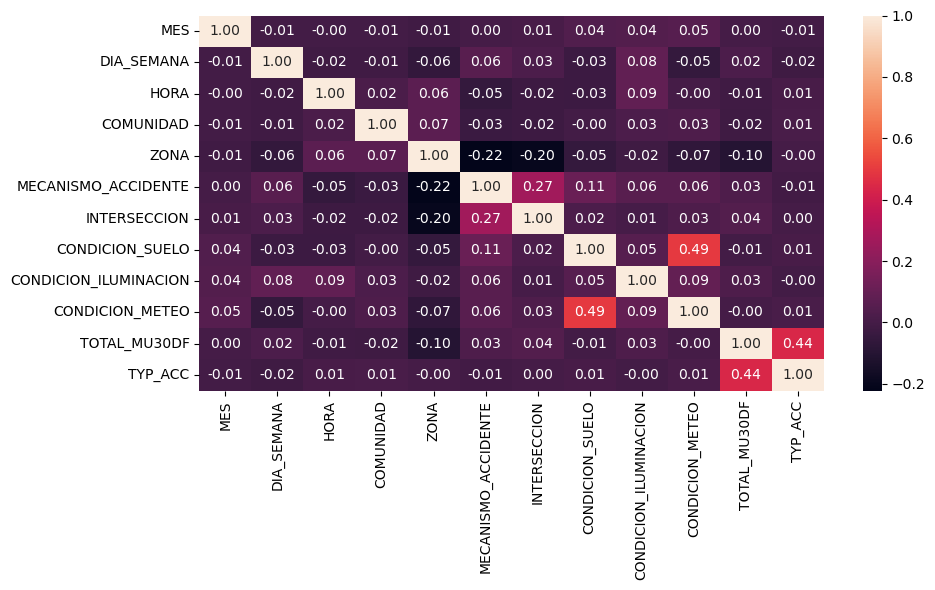

In [121]:
df_subset = df[['MES', 'DIA_SEMANA', 'HORA', 'COMUNIDAD','ZONA','MECANISMO_ACCIDENTE','INTERSECCION', 
            'CONDICION_SUELO', 'CONDICION_ILUMINACION','CONDICION_METEO','TOTAL_MU30DF', 'TYP_ACC']]
#Necesitamos convertir primero la variables categóricas a numéricas
df_subset["TYP_ACC"] = pd.factorize(df_subset["TYP_ACC"])[0]
df_subset["COMUNIDAD"] = pd.factorize(df_subset["COMUNIDAD"])[0]

#Crear la matriz
fig, axis = plt.subplots(figsize = (10, 6))

sns.heatmap(df_subset.corr(), annot = True, fmt = ".2f")
plt.tight_layout()
plt.show()

Lo primero que se observa es la nula influencia de todas las variables en el tipo de accidente, esto era de esperar dado lo exageradamente poblado que está el dataset de accidentes tipo 'Sin Lesiones', por tanto, este primer análisis no concluye que las variables dependientes son incapaces de predecir la variable dependiente, sino que se requiere de más técnicas y un análisis más profundo.

Respecto a la relación entre variables dependientes, la más fuerte es entre la condicion del suelo y las condiciones meteorológicas, casi un 50% de correlación, además el mecanismo del accidente parece relacionarse bastante con si se da en una intersección o no.
El mecanismo y la si hay intersección tienen alrededor de un 20% de correlación con la zona, que tiene también un 16% de correlación con el número de víctimas del accidente.

In [122]:
print(df.columns)

Index(['MES', 'DIA_SEMANA', 'HORA', 'COD_PROVINCIA', 'ZONA', 'CARRETERA',
       'MECANISMO_ACCIDENTE', 'TOTAL_HG24H', 'TOTAL_HL24H', 'TOTAL_MU30DF',
       'TOTAL_HG30DF', 'TOTAL_HL30DF', 'TOTAL_VICTIMAS_30DF',
       'TOTAL_VEHICULOS', 'TOT_PEAT_MU30DF', 'TOT_BICI_MU30DF',
       'TOT_CICLO_MU30DF', 'TOT_MOTO_MU30DF', 'TOT_TUR_MU30DF',
       'TOT_FURG_MU30DF', 'TOT_CAM_MAS3500_MU30DF', 'TOT_VMP_MU30DF',
       'TOT_OTRO_MU30DF', 'INTERSECCION', 'CONDICION_SUELO',
       'CONDICION_ILUMINACION', 'CONDICION_METEO', 'TYP_ACC', 'COMUNIDAD'],
      dtype='object')


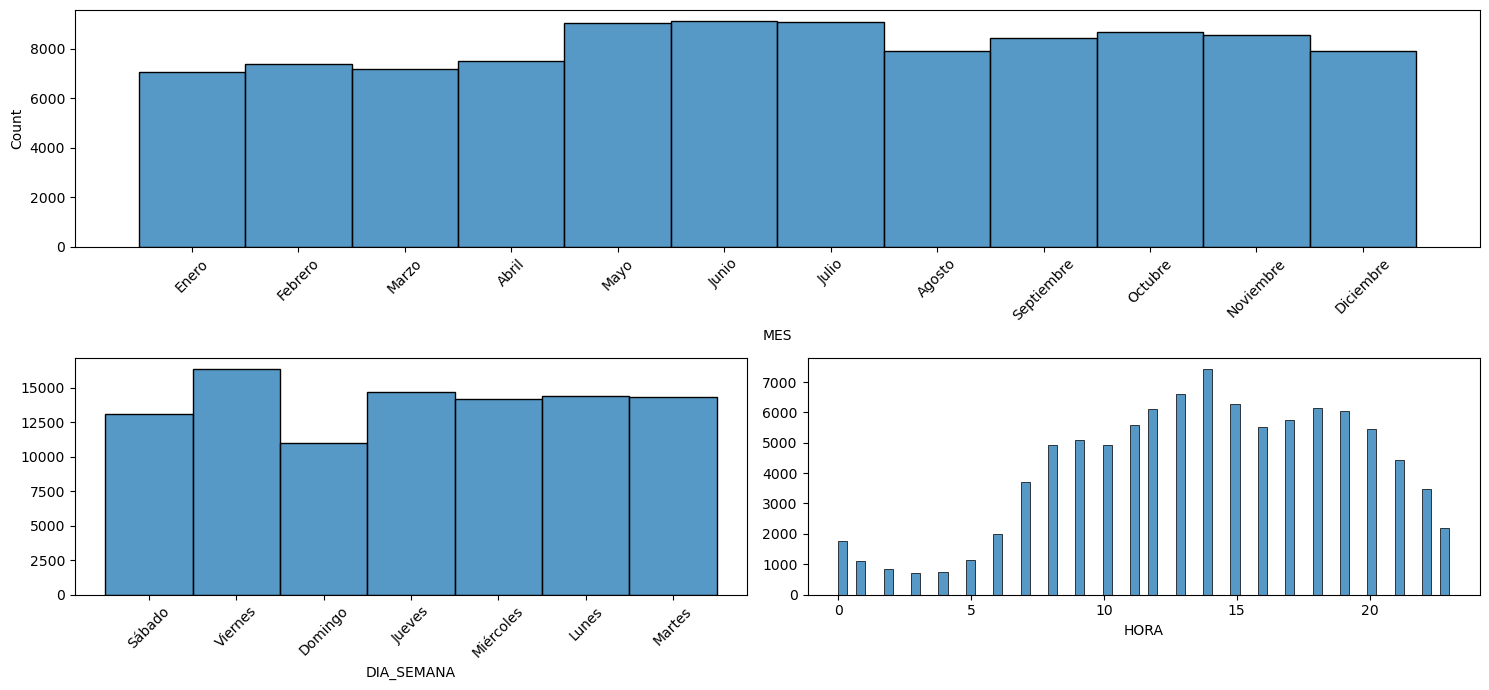

In [126]:
#Relación entre la fecha y los accidentes
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(2, 2, figure=fig)
ax_mes = fig.add_subplot(gs[0, :])      # Ocupa toda la primera fila
ax_dia = fig.add_subplot(gs[1, 0])      # Segunda fila, primera columna
ax_hora = fig.add_subplot(gs[1, 1])     # Segunda fila, segunda columna

sns.histplot(data=df_eda, x='MES', ax=ax_mes)
ax_mes.tick_params(axis='x', rotation=45)

#Ordenar columna dias de la semana
sns.histplot(data=df_eda, x='DIA_SEMANA', ax=ax_dia).set(ylabel=None)
ax_dia.tick_params(axis='x', rotation=45)
sns.histplot(data=df_eda, x='HORA', ax=ax_hora).set(ylabel=None)

plt.tight_layout()
plt.show()

<font color="red">No entiendo por que los días de la semana salen desordenados </font>

Los accidentes son relativamente constantes, pero los 4 primeros meses del año se mantienen más bajos (~6000). Pero los meses de Mayo a Julio suben de manera abrupta pasándo de largo los 8000 incidentes por mes. Es cierto lo de que la primavera la sangre altera. El resto del año se mantienen en un punto medio alrededor de 8000.

Respecto a los días de la semana entre diario se mantienen bastante constantes pero suben los viernes que es el día de más accidentes, supongo que se debe a que la gente sale más de fiesta ese día y que se toma más alcohol. Los domingos al contrario es el día que menos accidentes hay ya que probablemente también sea el día que menos se coge el coche. Lo que resulta curioso de este gráfico es que el número de accidentes es bastante constante siempre, la diferencia entre el día que más accidentes se producen y el que menos no es ni del 50%, esperábamos tendencias mucho más marcadas. Tal vez si miramos el tipo de accidentes o el número de víctimas si que veamos tendencias más marcadas.

La hora si presenta mayores tendencias. Las horas de la madrugada son las que menos accidentes tienen a pesar de que probablemente sea cuando los conductores están más cansados o bajo más sustancias, el considerable menor número de vehículos circulando a esa pesa demasiado en este gráfico, si tuviesemos los datos del número aproximado de vehículos circulando podríamos observar mejor si existe una mayor probabilidad de tener un accidente a esas horas. 
El mayor número de accidentes se produce a las 14:00, esto se debe a que a esa hora es hora punta, pero seguramente la mayoría de esos accidentes sean pequeños golpes y seguramente el número de accidentes mortales a esa hora no es muy alto, pero lo comprobaremos más adelante. Creo que este gráfico está demasiado influenciado por la densidad de tráfico a ciertas horas como para poder sacar mayores conclusiones.

In [ ]:
df.columns

Index(['MES', 'DIA_SEMANA', 'HORA', 'COD_PROVINCIA', 'ZONA', 'CARRETERA',
       'MECANISMO_ACCIDENTE', 'TOTAL_HG24H', 'TOTAL_HL24H', 'TOTAL_MU30DF',
       'TOTAL_HG30DF', 'TOTAL_HL30DF', 'TOTAL_VICTIMAS_30DF',
       'TOTAL_VEHICULOS', 'TOT_PEAT_MU30DF', 'TOT_BICI_MU30DF',
       'TOT_CICLO_MU30DF', 'TOT_MOTO_MU30DF', 'TOT_TUR_MU30DF',
       'TOT_FURG_MU30DF', 'TOT_CAM_MAS3500_MU30DF', 'TOT_VMP_MU30DF',
       'TOT_OTRO_MU30DF', 'INTERSECCION', 'CONDICION_SUELO',
       'CONDICION_ILUMINACION', 'CONDICION_METEO', 'TYP_ACC', 'COMUNIDAD'],
      dtype='object')

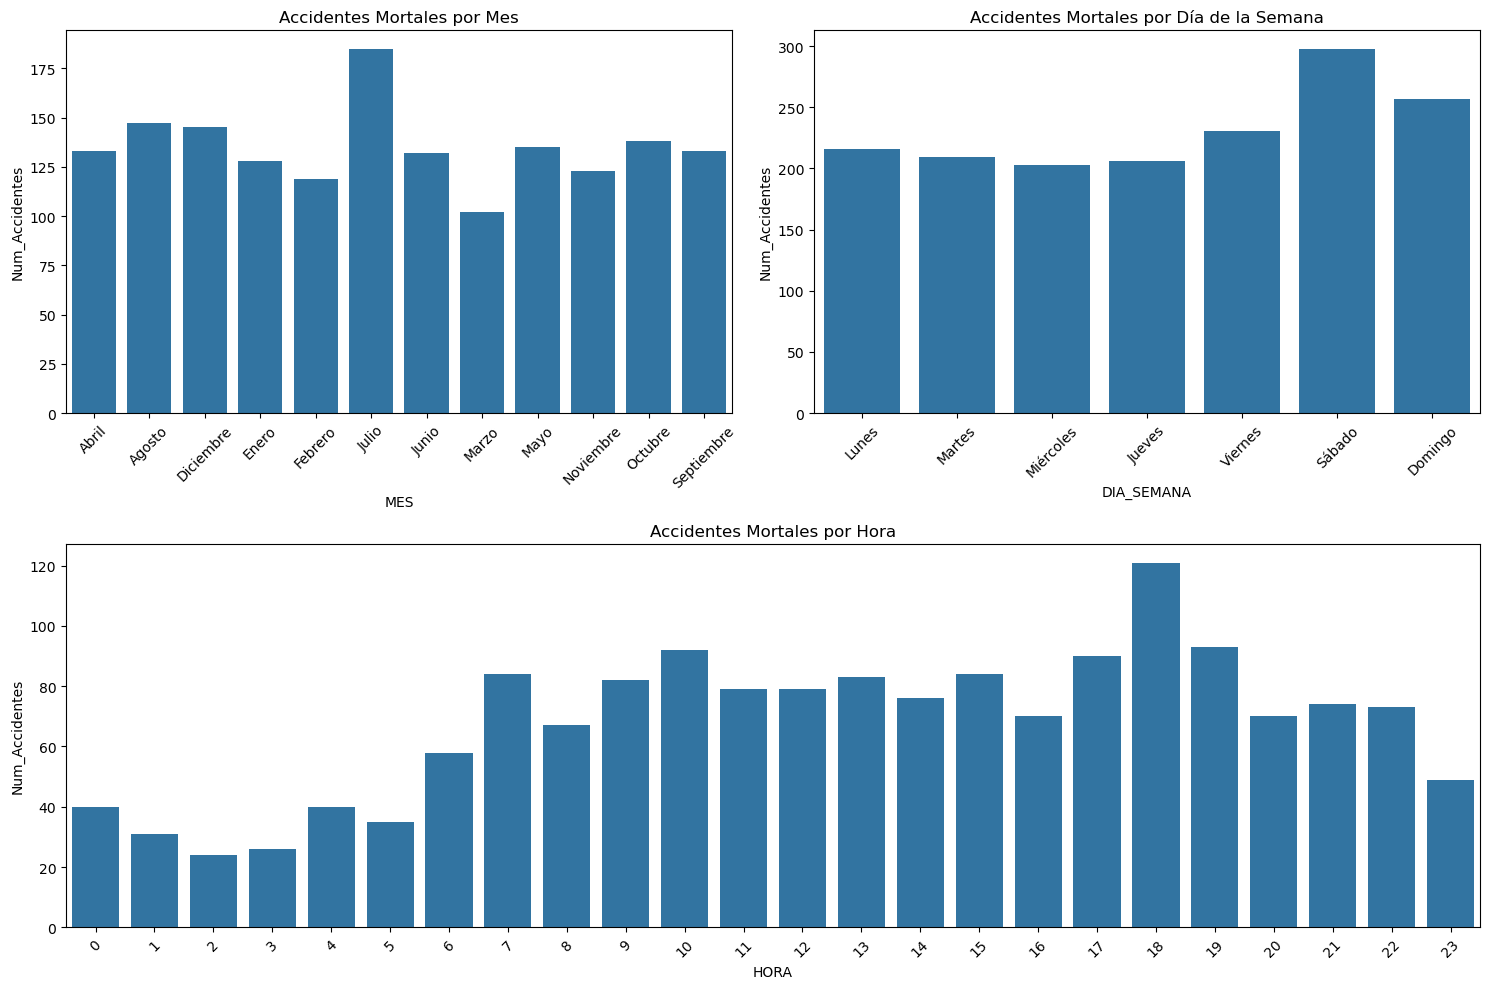

In [127]:
#Cantidad de accidentes graves y mortales en función de la fecha
# Filtrar solo los accidentes mortales (ajusta 'TYP_ACC' según cómo esté mapeado, por ejemplo, 'Mortal')
df_mortal = df_eda[df_eda['TYP_ACC'] == 'Mortal']

# Agrupar por MES y contar
acc_mes = df_mortal.groupby('MES').size().reset_index(name='Num_Accidentes')
acc_mes['MES'] = pd.Categorical(acc_mes['MES'], ordered=True)
acc_mes = acc_mes.sort_values('MES')

# Agrupar por DIA_SEMANA y contar
acc_dia = df_mortal.groupby('DIA_SEMANA').size().reset_index(name='Num_Accidentes')
ordered_days = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
acc_dia['DIA_SEMANA'] = pd.Categorical(acc_dia['DIA_SEMANA'], categories=ordered_days, ordered=True)
acc_dia = acc_dia.sort_values('DIA_SEMANA')

# Agrupar por HORA y contar
acc_hora = df_mortal.groupby('HORA').size().reset_index(name='Num_Accidentes')
acc_hora = acc_hora.sort_values('HORA')

# Configurar el layout
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax_mes = fig.add_subplot(gs[0, 0])
ax_dia = fig.add_subplot(gs[0, 1])
ax_hora = fig.add_subplot(gs[1, :])

# Graficar número de accidentes mortales por MES
sns.barplot(ax=ax_mes, data=acc_mes, x='MES', y='Num_Accidentes')
ax_mes.set_title('Accidentes Mortales por Mes')
ax_mes.tick_params(axis='x', rotation=45)

# Graficar número de accidentes mortales por Día de la Semana
sns.barplot(ax=ax_dia, data=acc_dia, x='DIA_SEMANA', y='Num_Accidentes')
ax_dia.set_title('Accidentes Mortales por Día de la Semana')
ax_dia.tick_params(axis='x', rotation=45)

# Graficar número de accidentes mortales por HORA
sns.barplot(ax=ax_hora, data=acc_hora, x='HORA', y='Num_Accidentes')
ax_hora.set_title('Accidentes Mortales por Hora')
ax_hora.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# PREGUNTAS EDA:
- Hacer la matrix donde se vean todas las variables, sacar las columnas de cada tipo de fallecido. <font color="green">Listo</font>
- Cual es la distribución de accidentes en meses dias y hora, es decir que meses, días, horas son más peligrosos para conducir? <font color="red">Carlos</font>
- Existe algún o algunos municipios con un volumen sobresaliente de accidentes? Si no, crear comunidades y probar.
- Explorar el total de fallecidos de cada categoría, cuales más cuales menos etc.
- Tiene algún impacto la hora del día o el día de la semana sobre el tipo de accidente? Es decir si es por la mañana aumentan las probabilidades de que sea un atropello y si es por la tarde las probabilidades de que sea una colisión por ejemplo.
- Promedio victimas por accidente

# Ideas: 
- Columna comunidad autonoma


<font color="red">Para poner mensajes en rojo </font>